# Homework 4 - UFOs!!!

The objective of this homework is to practice cleaning and transforming data. To successfully complete this homework, you may use any resources available to you. 

Get the `scrubbed.csv` data [here](https://www.kaggle.com/NUFORC/ufo-sightings/data). Develop **three** interesting insights into the UFO phenomenon. 
1. When and where do people see UFOs in California? 
2. Are there differences in the circumstances of UFO sightings across the U.S. states? (Explore the comment column)
3. What is the average length of UFO sightings across the U.S. states?

Hints:
* When you explore the comment column, think about the work we did on twitter. 
* For better performance, download the data to your local drive.
* Make reasonable assumptions when transforming the length data.

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd

In [5]:
ufos_raw = pd.read_csv('scrubbed.csv', parse_dates=['datetime']).rename(columns=lambda x: x.strip())

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
ufos_raw['duration (seconds)'].replace(to_replace = r'[^0-9.]+', value='', regex=True, inplace=True)
ufos_raw['duration (seconds)'] = pd.to_numeric(ufos_raw['duration (seconds)'])

In [7]:
ufos_raw['latitude'].replace(to_replace = r'[^0-9.]+', value='', regex=True, inplace=True)
ufos_raw['latitude'] = pd.to_numeric(ufos_raw['latitude'])
ufos_raw['longitude'] = pd.to_numeric(ufos_raw['longitude'])

In [8]:
ufos_raw = ufos_raw.rename(columns={'duration (seconds)': 'duration_sec'})

In [9]:
ufos_raw = ufos_raw.drop(['duration (hours/min)', 'date posted'], axis=1)

In [10]:
ufos_ca = ufos_raw[ufos_raw['state']=='ca'].copy()

In [11]:
ufos_ca['new_date'] = pd.to_datetime(ufos_ca['datetime'], errors='coerce')

In [12]:
ufos_ca['datetime'] = ufos_ca['datetime'].str.replace('24:00', '00:00')

In [ ]:
ufos_ca.loc[pd.isnull(ufos_ca['new_date'])]

In [16]:
ufos_ca = ufos_ca.set_index(pd.DatetimeIndex(ufos_ca['datetime']))

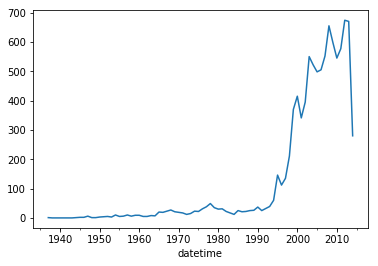

In [17]:
ufos_ca.resample('Y').count()['datetime'].plot()

In [18]:
ufos_ca['hours'] = ufos_ca.index.hour

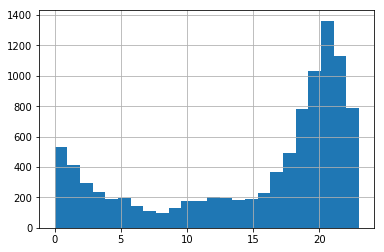

In [19]:
ufos_ca.hours.hist(bins=24)

In [20]:
from bokeh.io import output_file, output_notebook, show
from bokeh.models import GMapPlot, GMapOptions, ColumnDataSource, Circle, Range1d

In [21]:
from configparser import ConfigParser
config = ConfigParser()
config.read('google_config.cfg')

['google_config.cfg']

In [22]:
http://bokeh.pydata.org/en/latest/docs/user_guide/geo.html

SyntaxError: invalid syntax (<ipython-input-22-6e6be3663d9f>, line 1)

In [23]:
map_options = GMapOptions(lat=37.88, lng=-122.23, map_type="terrain", zoom=6)

plot = GMapPlot(x_range=Range1d(), y_range=Range1d(), map_options=map_options)

plot.title.text = "UFO Sightings in California 1944 - 2013"

plot.api_key = config.get('maps','api_key')

source = ColumnDataSource(
    data=dict(
        lat=ufos_ca.latitude.tolist(),
        lon=ufos_ca.longitude.tolist(),
    )
)

circle = Circle(x="lon", y="lat", fill_color='red', fill_alpha=0.5, line_color=None)
plot.add_glyph(source, circle)

output_notebook()

show(plot)

GlyphRenderer(id='1ddb5557-22d2-41a7-962c-3796b543aefd', ...)

Loading BokehJS ...

In [61]:
#!pip install nltk
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer


In [62]:
sw = set(stopwords.words('english'))
stem = SnowballStemmer("english")

In [26]:
ufos_comments = ufos_raw.copy()

In [77]:
ufos_comments['clean_comments'] = ufos_comments['comments'].str.strip() \
.str.lower() \
.str.replace(r'&#\d+','') \
.str.replace(r'[^A-Za-z0-9 ]+','') \
.str.replace(r'\d+','') \
.str.replace(r'\s{2,}',' ')

stops = r'\b(?:{})\b'.format('|'.join(sw))

ufos_comments['clean_comments_wo_stop'] = ufos_comments['clean_comments'].str.replace(stops, '')
ufos_comments['clean_comments_wo_stop'] = ufos_comments['clean_comments_wo_stop'].str.replace(r'\W*\b\w{1,3}\b', '')
ufos_comments['clean_comments_wo_stop'] = ufos_comments['clean_comments_wo_stop'] \
.apply(lambda x: ' '.join(stem.stem(word) for word in str(x).split(' ')) )

In [80]:
def full_words(x):
    txt = x['clean_comments_wo_stop'].str.cat(sep=' ')
    return txt

In [85]:
words_by_state = ufos_comments[ufos_comments['country']=='us'].groupby('state').apply(lambda x: full_words(x))

In [120]:
def count_words(x):
    words = nltk.tokenize.word_tokenize(x)
    return pd.DataFrame(nltk.FreqDist(words).most_common(10),columns=['word', 'frequency'])

In [121]:
states = pd.DataFrame()
for state, words in words_by_state.iteritems():
    result = count_words(words)
    result['place'] = result.index+1
    result['state'] = state
    states = states.append(result)

In [183]:
unique_words = states['word'].value_counts()==1
unique_words = unique_words[unique_words]

In [186]:
states[states['word'].isin(unique_words.index)].groupby('state')['word'].apply(lambda x: x.str.cat(sep=' '))

state
ak                            alaska anchorag
al                                    alabama
ar                                    arkansa
az                            phoenix arizona
co                            colorado denver
dc    lumin thought group dartingrevolv round
de                                    delawar
fl                                    florida
ga                                    georgia
hi                         hawaii flash green
ia                               iowa triangl
id                                      idaho
in                                    indiana
ks                                      kansa
ky                                   kentucki
la                                  louisiana
md                                   maryland
me                                       main
mi                                   michigan
mo                                   missouri
mt                                    montana
nd                          

In [57]:
ufos_raw[ufos_raw['country']=='us'].groupby('state')['duration_sec'].agg(['mean','count']).sort_values('mean', ascending=False)

,mean,count
state,,
ar,113930.296769,588
hi,25708.198473,262
fl,14593.241199,3835
wa,14470.397413,3966
ct,14132.476233,892
la,12254.166667,558
va,10712.976434,1273
ms,9064.805333,375
ga,7600.329163,1255
